In [55]:
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

import sqlite3
import argparse
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
from numpy.linalg import norm
import sys

Download code Bert model

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
model.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

Connect to the database

In [57]:
database_path = "./dbrd_processed.db"


conn = sqlite3.connect(database_path)
cursor = conn.cursor()

Names in the database

In [58]:
def get_project_names(conn):
    cursor = conn.cursor()

    # Fetch table names using SQL query
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    # Extract table names from the result
    project_names = [table[0] for table in tables]
    return project_names

project_names = get_project_names(conn)
column_names = ['bug_id',
                'key',
                'creation_ts',
                'short_desc',
                'product',
                'component',
                'version',
                'bug_status',
                'resolution',
                'priority',
                'bug_severity',
                'description',
                'code_feature',
                'dup_id']


## Utils

### Union-find

In [59]:
class UnionFind:
    def __init__(self):
        self.parent = {}  # Dictionary to store parent nodes
        self.ranks = {}    # Dictionary to store rank (or size) of each set
        self.processed = False

    def find(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.ranks[x] = 1
            return x

        # Path compression
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)

        if root_x != root_y:
            if self.ranks[root_x] < self.ranks[root_y]:
                self.parent[root_x] = root_y
                self.ranks[root_y] += self.ranks[root_x]
            else:
                self.parent[root_y] = root_x
                self.ranks[root_x] += self.ranks[root_y]
            
    def process_project(self, conn, project_name):
        cursor = conn.cursor()
        
        cursor.execute(f"SELECT * FROM {project_name}")
        for row in cursor.fetchall():
            dup_id = int(row[column_names.index("dup_id")])
            if dup_id == -1: continue
            bug_id = int(row[column_names.index("bug_id")])
            assert(dup_id != bug_id)
            self.union(bug_id, dup_id)
        self.processed = True
            
    def get_roots(self,):
        assert(self.processed)
        return list(set(self.parent.values()))
    
    def get_children(self, parent):
        assert(self.processed)
        parent = self.find(parent)
        children = [key for key, value in self.parent.items() if value == parent]
        return children
    
    def are_dups(this, bug_id1, bug_id2):
        return this.parent[bug_id1] == this.parent[bug_id2]
            

In [60]:
def get_bug_ids(conn, table_name):
    cursor = conn.cursor()
    column_name = "bug_id"

    # Fetch table names using SQL query
    cursor.execute(f"SELECT DISTINCT {column_name} FROM {table_name} ORDER BY {column_name};")
    distinct_values_sorted = cursor.fetchall()

    # Extract table names from the result
    return [value[0] for value in distinct_values_sorted]

In [61]:
def vectorize(description, stride_len, chunk_size):
    tokens = tokenizer.tokenize(description)
    # if len og token array is < 32, we do nothing as there is not enough information
    if (len(tokens) < chunk_size // 2): return None

    # remember to add cls and sep token at each chunk
    token_ids = tokenizer.convert_tokens_to_ids([tokenizer.cls_token]+tokens+[tokenizer.sep_token])

    # divide token ids into batche of chunks
    chunk_list=[]
    for i in range(0, len(token_ids), stride_len):
        chunk = token_ids[i:min(i+chunk_size, len(token_ids))]
        assert(len(chunk) <= chunk_size)
        if len(chunk) < chunk_size:
            # keep going
            continue
            # if (len(chunk) < chunk_size // 2): continue
            # pad_length = chunk_size - len(chunk)
            # chunk += [tokenizer.pad_token_id]*pad_length
        assert(len(chunk) == chunk_size)
        # print(chunk)
        chunk_list.append(chunk)

    if(len(chunk_list) == 0): return None
    chunk_arr = np.array(chunk_list)
    # print("Chunk arr size{}".format(chunk_arr.shape))
    # context_embedding = model(torch.tensor(token_ids[:512])[None, :])[0]
    context_embedding = model(torch.tensor(chunk_arr)[:, :])[0]
    return context_embedding.detach().numpy()

In [62]:
def get_descriptions(conn, project_name, bug_id):
    cursor = conn.cursor()

    # Fetch table names using SQL query
    query = f"SELECT * FROM {project_name} WHERE bug_id = {bug_id};"
    # print(query)
    cursor.execute(query)
    result = cursor.fetchall()[0]
    desc = result[column_names.index("description")]
    short_desc = result[column_names.index("short_desc")]

    # Extract table names from the result
    return (desc + "\n" + short_desc).replace("\\'", "'")

Calculate similarity

In [63]:
def similarity_score_1d(vector1, vector2):
    assert(len(vector1.shape) == 1)
    assert(len(vector2.shape) == 1)
    assert(vector1.shape[0] == vector2.shape[0])
    return np.dot(vector1,vector2)/(norm(vector1)*norm(vector2))

In [64]:
def similarity_score_2d(vector1, vector2):
    # print(vector1.shape)
    # print(vector2.shape)
    assert(len(vector1.shape) == 2)
    assert(len(vector2.shape) == 2)
    max_score = 0
    min_score = sys.maxsize
    total_score = 0
    num_scores = 0
    high_score_count = 0
    for v in vector1:
        for u in vector2:
            sim_score = np.dot(v,u)/(norm(v)*norm(u))
            if sim_score > max_score:
                max_score = sim_score
            if sim_score < min_score:
                min_score = sim_score
            total_score += sim_score
            num_scores += 1
            if sim_score > 0.99:
                high_score_count += 1
    return (max_score, min_score, total_score/num_scores)

In [65]:
def reshape_3d_to_2d(vector):
    assert(len(vector.shape) == 3)
    first_dim = vector.shape[0]
    second_dim = vector.shape[1]
    new_dim = first_dim * second_dim
    return vector.reshape(new_dim, vector.shape[2])

In [66]:
def similarity_score_3d(vector1, vector2):
    assert(len(vector1.shape) == 3)
    assert(len(vector2.shape) == 3)
    assert(vector1.shape[1] == vector2.shape[1])
    assert(vector1.shape[2] == vector2.shape[2])
    vec1_2d = reshape_3d_to_2d(vector1)
    vec2_2d = reshape_3d_to_2d(vector2)
    score = similarity_score_2d(vec1_2d, vec2_2d)
    return score
    # max_score = 0
    # min_score = sys.maxsize
    # total_score = 0
    # num_scores = 0
    # for v in vector1:
    #     for u in vector2:
    #         sim_score = similarity_score_2d(u, v)
    #         if sim_score[0] > max_score:
    #             max_score = sim_score[0]
    #         if sim_score[1] < min_score:
    #             min_score = sim_score[1]
    #         total_score += sim_score[2]
    #         num_scores += 1
    # return (max_score, min_score, total_score/num_scores)

In [67]:
def similarity_score_matrix_3d(folder_name, project_name, bug_id1, bug_id2):
    if (bug_id1 > bug_id2):
        temp = bug_id1
        bug_id1 = bug_id2
        bug_id2 = temp
    file_name = f"sim_scores_{bug_id1}_{bug_id2}.npz"
    file_path = os.path.join(f"./{folder_name}", project_name, file_name)
    vector1 = load_vector_from_file(folder_name, project_name, bug_id1)
    vector2 = load_vector_from_file(folder_name, project_name, bug_id2)
    if (vector1 is None or vector2 is None):
        return
    assert(len(vector1.shape) == 3)
    assert(len(vector2.shape) == 3)
    assert(vector1.shape[1] == vector2.shape[1])
    assert(vector1.shape[2] == vector2.shape[2])
    vec1_2d = reshape_3d_to_2d(vector1)
    vec2_2d = reshape_3d_to_2d(vector2)
    M = vec1_2d.shape[0]
    N = vec2_2d.shape[0]
    similarity_scores = np.zeros((M, N))
    # for m in range(M):
    #     v = vec1_2d[m]
    #     for n in range(m+1, N):
    #         if (similarity_scores[m, n] != 0): continue
    #         u = vec2_2d[n]
    #         sim_score = np.dot(v,u)/(norm(v)*norm(u))
    #         similarity_scores[m, n] = sim_score
            
    # for n in range(N):
    #     u = vec2_2d[n]
    #     for m in range(n+1, M):
    #         if (similarity_scores[m, n] != 0): continue
    #         v = vec1_2d[m]
    #         sim_score = np.dot(v,u)/(norm(v)*norm(u))
    #         similarity_scores[m, n] = sim_score
    
    for m in range(M):
        v = vec1_2d[m]
        for n in range(N):
            if (similarity_scores[m, n] != 0): continue
            u = vec2_2d[n]
            sim_score = np.dot(v,u)/(norm(v)*norm(u))
            similarity_scores[m, n] = sim_score

    # np.savez(file_path, similarity_scores)
    return similarity_scores

In [68]:
def similarity_score_matrix_3d(vector1, vector2):
    if (vector1 is None or vector2 is None):
        return
    assert(len(vector1.shape) == 3)
    assert(len(vector2.shape) == 3)
    # assert(vector1.shape[1] == vector2.shape[1])
    # assert(vector1.shape[2] == vector2.shape[2])
    vec1_2d = reshape_3d_to_2d(vector1)
    vec2_2d = reshape_3d_to_2d(vector2)
    M = vec1_2d.shape[0]
    N = vec2_2d.shape[0]
    similarity_scores = np.zeros((M, N))
    # for m in range(M):
    #     v = vec1_2d[m]
    #     for n in range(m+1, N):
    #         if (similarity_scores[m, n] != 0): continue
    #         u = vec2_2d[n]
    #         sim_score = np.dot(v,u)/(norm(v)*norm(u))
    #         similarity_scores[m, n] = sim_score
            
    # for n in range(N):
    #     u = vec2_2d[n]
    #     for m in range(n+1, M):
    #         if (similarity_scores[m, n] != 0): continue
    #         v = vec1_2d[m]
    #         sim_score = np.dot(v,u)/(norm(v)*norm(u))
    #         similarity_scores[m, n] = sim_score
    
    for m in range(M):
        v = vec1_2d[m]
        for n in range(N):
            if (similarity_scores[m, n] != 0): continue
            u = vec2_2d[n]
            sim_score = np.dot(v,u)/(norm(v)*norm(u))
            similarity_scores[m, n] = sim_score

    # np.savez(file_path, similarity_scores)
    return similarity_scores

In [69]:
def plot_2d_array(data):
    # Create a sample 2D array

    # Plotting the heatmap
    plt.imshow(data, cmap='viridis', interpolation='nearest')

    # Adding colorbar
    plt.colorbar()

    # Show the plot
    plt.show()

## Processing

Processing first project

In [64]:
project_name = "spark"

bug_ids = get_bug_ids(conn, project_name)

union_find = UnionFind()
union_find.process_project(conn, project_name)

Preparing a table of scores
Initialized with value -1
If bug report is too short, all of its scores becomes -2
Otherwise, must be updated to a value >= 0

In [65]:
num_bug_ids = len(bug_ids)
similarity_scores = np.ones((num_bug_ids, num_bug_ids)) * -1
np.fill_diagonal(similarity_scores, -2)
similarity_scores[np.tril_indices(len(similarity_scores), k=-1)] = -2


Two nesting loop to go through each pair of combinations

In [13]:
for i in tqdm(range(0, num_bug_ids)):
    bug_id1 = bug_ids[i]
    desc1 = get_descriptions(conn, project_name, bug_id1)
    vector1 = vectorize(desc1, 64, 128)
    for j in range(i+1, num_bug_ids):
        bug_id2 = bug_ids[j]
        desc2 = get_descriptions(conn, project_name, bug_id2)
        vector2 = vectorize(desc2, 64, 128)
        
        

  0%|          | 0/27583 [00:00<?, ?it/s]

SELECT * FROM eclipse WHERE bug_id = 529329;
SELECT * FROM eclipse WHERE bug_id = 529330;
SELECT * FROM eclipse WHERE bug_id = 529331;
SELECT * FROM eclipse WHERE bug_id = 529332;
SELECT * FROM eclipse WHERE bug_id = 529334;
SELECT * FROM eclipse WHERE bug_id = 529335;
SELECT * FROM eclipse WHERE bug_id = 529337;
SELECT * FROM eclipse WHERE bug_id = 529338;
SELECT * FROM eclipse WHERE bug_id = 529339;
SELECT * FROM eclipse WHERE bug_id = 529341;
SELECT * FROM eclipse WHERE bug_id = 529342;
SELECT * FROM eclipse WHERE bug_id = 529343;
SELECT * FROM eclipse WHERE bug_id = 529344;
SELECT * FROM eclipse WHERE bug_id = 529345;
SELECT * FROM eclipse WHERE bug_id = 529346;
SELECT * FROM eclipse WHERE bug_id = 529347;


  0%|          | 0/27583 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for i in tqdm(range(0, num_bug_ids)):
    desc = get_descriptions(conn, project_name, bug_ids[i])
    vectorize(desc, 64, 128)

  7%|▋         | 1915/27583 [04:00<53:39,  7.97it/s]  


KeyboardInterrupt: 

In [54]:
for i in tqdm(range(0, num_bug_ids)):
    #load vector from saved file
    bug_id = bug_ids[i]
    file_name = "{}_{}.npz".format(project_name, bug_id)
    file_path = os.path.join("./vectorize", project_name, file_name)
    if os.path.exists(file_path):
        array = np.load(file_path)['arr_0']
    

100%|██████████| 27583/27583 [04:05<00:00, 112.40it/s]


In [ ]:
loaded_data = np.load('./vectorize/eclipse/eclipse_529330.npz')
array1 = loaded_data['arr_0']

Select set of reports

Spin up 8 threads to process

In [14]:
import threading
import time
from datetime import datetime

In [15]:
def load_vector_from_file(folder_name, project_name, bug_id):
    file_name = "{}_{}.npz".format(project_name, bug_id)
    file_path = os.path.join(f"./{folder_name}", project_name, file_name)
    if os.path.exists(file_path):
        array = np.load(file_path)['arr_0']
        return array
    return None

def file_exists(project_name, bug_id):
    file_name = "{}_{}.npz".format(project_name, bug_id)
    file_path = os.path.join("./vectorize", project_name, file_name)
    return os.path.exists(file_path)

In [16]:
roots = union_find.get_roots()
print(len(roots))
print(union_find.get_children(13145078))

for root in roots:
    children = union_find.get_children(root)
    if (len(children) < 2):
        print("Root has only {} children".format(len(children)))
    assert(root in children)

print(roots[1])


290
[13169540, 13145078]
13288450


In [136]:
duplicated_list = []
for root in roots[:len(roots)]:
    children = union_find.get_children(root)
    duplicated_list += children

number_of_duplicated = len(duplicated_list)
# nonduplicated_list = np.random.choice(bug_ids, number_of_duplicated).tolist()
# nonduplicated_list = [id for id in nonduplicated_list if file_exists(project_name, id)]
nonduplicated_list = []

# selected_bug_ids = np.sort(np.array(list(set(duplicated_list + nonduplicated_list))))
selected_bug_ids = np.sort(np.array(duplicated_list))

assert(len(duplicated_list) == len(set(duplicated_list)))



In [137]:
len(duplicated_list)

644

In [138]:
len(bug_ids)

9579

In [139]:
selected_bug_ids.shape

(644,)

In [140]:
num_selected_bug_ids = len(selected_bug_ids)
similarity_scores_avg = np.ones((num_selected_bug_ids, num_selected_bug_ids)) * -1
np.fill_diagonal(similarity_scores_avg, -2)
similarity_scores_avg[np.tril_indices(len(similarity_scores_avg), k=-1)] = -2


similarity_scores_max = similarity_scores_avg.copy()
similarity_scores_min = similarity_scores_avg.copy()


In [31]:
def compute_similarity(thread_id, num_threads, project_name):
    # section_size = len(selected_bug_ids)
    # if (num_threads != 1):
    section_size = len(selected_bug_ids) // (num_threads)
    start_index = thread_id
    end_index = len(selected_bug_ids)
    step = section_size
    # database_path = "./dbrd.db"
    # thread_conn = sqlite3.connect(database_path)
    # thread_cursor = thread_conn.cursor()
    # if (thread_id == 0):
        # print(f"Progress in {section_size} :")
    # with  tqdm(total=section_size*section_size//2, position=thread_id, desc="thread 0") as progress:
    for i in range(start_index, end_index, step):
        print("{} | Thread {}: {}".format(datetime.now(), thread_id, i))
        # if (thread_id == 0):
        #     current_time = datetime.now()

        #     # Format and print the current time
        #     formatted_time = current_time.strftime("%H:%M:%S")  # HH:MM:SS format
        #     print("Current time:", formatted_time)
        #     print(f"{i}", end=" ")
        # print(project_name)
        # print(selected_bug_ids[i])
        # desc1 = get_descriptions(thread_conn, project_name, selected_bug_ids[i])
        # vec1 = vectorize(desc1, 1, 1)
        vec1 = load_vector_from_file(project_name, selected_bug_ids[i])
        assert(vec1.shape[1] == 1)
        if vec1 is None:
            for j in range(i, len(selected_bug_ids)):
                similarity_scores[i, j] = -1
            continue
        vec1 = np.array([v[0] for v in vec1] )
        for j in range(i+1, len(selected_bug_ids), 1):
            if (thread_id == 0):
                print(j, end=" ")
            #     progress.update(1)
            # desc2 = get_descriptions(thread_conn, project_name, selected_bug_ids[j])
            # vec2 = vectorize(desc2, 1, 1)
            vec2 = load_vector_from_file(project_name, selected_bug_ids[j])
            if vec2 is None:
                similarity_scores[i, j] = -1
                continue
            
            vec2 = np.array([v[0] for v in vec2] )
            sim_score = similarity_score_2d(vec1, vec2)
            similarity_scores_max[i, j] = sim_score[0]
            similarity_scores_min[i, j] = sim_score[1]
            similarity_scores_avg[i, j] = sim_score[2]
        print("\n") 
    # thread_conn.close()      
    return

In [32]:
num_threads = 32
threads = []
for i in range(num_threads):
    threads.append(threading.Thread(target=compute_similarity, args=(i, num_threads, project_name)))

for i in range(num_threads):
    threads[i].start()
    

for i in range(num_threads):
    threads[i].join()
    
print("End threading")
np.savez("similarity_scores_avg", similarity_scores_avg)
np.savez("similarity_scores_min", similarity_scores_min)
np.savez("similarity_scores_max", similarity_scores_max)

2023-11-09 04:13:27.369342 | Thread 0: 0
2023-11-09 04:13:27.370936 | Thread 1: 1
2023-11-09 04:13:27.371842 | Thread 2: 2
2023-11-09 04:13:27.372539 | Thread 3: 3
2023-11-09 04:13:27.372883 | Thread 4: 4
2023-11-09 04:13:27.373461 | Thread 5: 5
2023-11-09 04:13:27.374510 | Thread 6: 6
2023-11-09 04:13:27.376462 | Thread 7: 7
2023-11-09 04:13:27.378035 | Thread 8: 8
2023-11-09 04:13:27.379368 | Thread 9: 9
2023-11-09 04:13:27.380056 | Thread 10: 10
2023-11-09 04:13:27.381664 | Thread 11: 11
2023-11-09 04:13:27.382253 | Thread 12: 12
2023-11-09 04:13:27.384191 | Thread 13: 13
2023-11-09 04:13:27.386978 | Thread 14: 14
2023-11-09 04:13:27.390020 | Thread 15: 15
2023-11-09 04:13:27.390461 | Thread 16: 16
2023-11-09 04:13:27.392846 | Thread 17: 17
2023-11-09 04:13:27.397409 | Thread 18: 18
2023-11-09 04:13:27.398520 | Thread 19: 19
2023-11-09 04:13:27.401132 | Thread 20: 20
2023-11-09 04:13:27.402350 | Thread 21: 21
2023-11-09 04:13:27.405539 | Thread 22: 22
2023-11-09 04:13:27.408167 | Th

In [30]:
np.savez("similarity_scores_avg", similarity_scores_avg)
np.savez("similarity_scores_min", similarity_scores_min)
np.savez("similarity_scores_max", similarity_scores_max)

In [178]:
get_descriptions(conn, project_name, 529329)

SELECT * FROM eclipse WHERE bug_id = 529329;


'your eclipse not running or working.please correct it.\nyour eclipse not running or working.please correct it.'

In [18]:
print(selected_bug_ids.shape)

(4249,)


In [21]:
vec2 = load_vector_from_file(project_name, 13127845)

In [23]:
vec2.shape

(462, 1, 768)

In [20]:
union_find.get_children(roots[0])

[13285890, 13254983]

In [32]:
vec1 = load_vector_from_file(project_name, 13285890)
vec1 = np.array([v[0] for v in vec1])
vec2 = load_vector_from_file(project_name, 13254983)
vec2 = np.array([v[0] for v in vec2])

vec3 = load_vector_from_file(project_name, 13128106)
vec3 = np.array([v[0] for v in vec3])

vec4 = load_vector_from_file(project_name, 13348337)
vec4 = np.array([v[0] for v in vec4])

In [22]:
similarity_score_2d(vec1, vec2)

(1.0000002, 0.9999975, 0.9999995904810288)

In [24]:
similarity_score_2d(vec1, vec3)

(1.0000002, 0.99999654, 0.9999997026108681)

In [30]:
similarity_score_1d(vec1[0]*100, vec3[1]*100)

0.99999976

In [28]:
vec1[0]*10

array([-1.29971611e+00,  3.64062524e+00,  4.18271899e-01, -5.09180307e-01,
        7.35545382e-02, -1.86309588e+00, -1.18745732e+00,  3.21368814e-01,
        1.81408003e-01, -8.79562736e-01,  1.64674163e+00,  4.55390024e+00,
       -1.50769413e+00,  9.27534625e-02,  2.49651861e+00,  1.63323134e-01,
        7.56912231e-01,  8.71441960e-01,  4.40602243e-01,  8.08974266e-01,
       -1.81185734e+00, -3.61422658e-01,  2.27963591e+00,  8.11176062e-01,
        4.11778307e+00, -2.16141820e-01,  2.82783771e+00,  2.45873761e+00,
        2.55602121e-01,  4.23319721e+00, -4.25843716e-01, -1.01510227e-01,
        1.33462667e+01, -1.26651633e+00,  1.80204761e+00, -6.78412795e-01,
       -1.81989133e-01,  2.87226677e+00, -1.35306430e+00,  2.04299420e-01,
       -3.90289187e+00, -9.03382823e-02, -9.23968697e+00,  1.72763181e+00,
        3.70866680e+00, -1.78383321e-01,  2.75372446e-01,  2.60811615e+00,
       -9.57559347e-01,  1.00842881e+00,  1.64816868e+00,  1.39271677e+00,
       -4.82323074e+00, -

In [31]:
vec3[0]*10

array([-1.29249084e+00,  3.63777781e+00,  4.23399538e-01, -5.11786103e-01,
        7.47781098e-02, -1.85845971e+00, -1.18907082e+00,  3.22463453e-01,
        1.82019591e-01, -8.84326935e-01,  1.64443004e+00,  4.54211378e+00,
       -1.50390983e+00,  9.53911692e-02,  2.49538875e+00,  1.68873161e-01,
        7.51633883e-01,  8.81303012e-01,  4.40381795e-01,  8.07001114e-01,
       -1.80725384e+00, -3.75910759e-01,  2.27466249e+00,  8.03131580e-01,
        4.10848904e+00, -2.06890091e-01,  2.81727195e+00,  2.45356965e+00,
        2.50195801e-01,  4.23120975e+00, -4.32547152e-01, -1.03654042e-01,
        1.33408270e+01, -1.26888728e+00,  1.80050611e+00, -6.77784383e-01,
       -1.90651193e-01,  2.86780930e+00, -1.35983837e+00,  1.97166115e-01,
       -3.90152240e+00, -8.99383277e-02, -9.23913288e+00,  1.73467016e+00,
        3.70687723e+00, -1.63211018e-01,  2.73611218e-01,  2.59661579e+00,
       -9.53045428e-01,  1.00355470e+00,  1.64675689e+00,  1.38660443e+00,
       -4.82615662e+00, -

In [33]:
vec4[0]*10

array([-1.29180300e+00,  3.63768816e+00,  4.24564213e-01, -5.12851536e-01,
        7.61273354e-02, -1.85731590e+00, -1.18962169e+00,  3.23152274e-01,
        1.82970196e-01, -8.83300960e-01,  1.64352393e+00,  4.54157066e+00,
       -1.50436306e+00,  9.68452170e-02,  2.49508214e+00,  1.68422624e-01,
        7.51626492e-01,  8.82704973e-01,  4.39172119e-01,  8.06280017e-01,
       -1.80711174e+00, -3.76266241e-01,  2.27340317e+00,  8.02632034e-01,
        4.10874748e+00, -2.07517132e-01,  2.81509137e+00,  2.45311642e+00,
        2.49621704e-01,  4.22967863e+00, -4.32460189e-01, -1.03013247e-01,
        1.33380985e+01, -1.26897931e+00,  1.80030608e+00, -6.76399112e-01,
       -1.92339212e-01,  2.86650300e+00, -1.36011958e+00,  1.97826013e-01,
       -3.90287113e+00, -9.04887915e-02, -9.23724270e+00,  1.73574376e+00,
        3.70623732e+00, -1.61388204e-01,  2.73872793e-01,  2.59531355e+00,
       -9.53783333e-01,  1.00329244e+00,  1.64722383e+00,  1.38788962e+00,
       -4.82564068e+00, -

In [35]:
similarity_score_2d(vec1*100, vec4*100)

(1.0000001, 0.9999978, 0.9999995967921089)

In [36]:
vec1.shape

(6, 768)

In [37]:
vec2.shape

(85, 768)

In [141]:
selected_bug_ids

array([13129687, 13130094, 13130533, 13130758, 13131042, 13131251,
       13131323, 13131391, 13131443, 13131653, 13131713, 13131871,
       13131947, 13132016, 13132089, 13132434, 13132436, 13132563,
       13132882, 13133126, 13133139, 13133526, 13134031, 13134138,
       13134140, 13134870, 13134871, 13135081, 13135082, 13137274,
       13137759, 13138115, 13138216, 13138646, 13138733, 13139219,
       13139260, 13139402, 13140553, 13141462, 13141684, 13142127,
       13142238, 13142715, 13143053, 13145024, 13145078, 13145818,
       13145952, 13146021, 13146087, 13146090, 13146271, 13146640,
       13147535, 13148782, 13149549, 13149895, 13150721, 13150938,
       13150977, 13151215, 13151638, 13152289, 13154038, 13154874,
       13155149, 13155360, 13155447, 13155769, 13156462, 13156549,
       13156550, 13157325, 13157793, 13158097, 13158822, 13158838,
       13159154, 13159445, 13159454, 13160381, 13160548, 13161249,
       13161398, 13161729, 13161761, 13162210, 13162690, 13162

In [39]:
vec1 = load_vector_from_file("vectorize_with_start_token_16_8", project_name, 13285890)
vec2 = load_vector_from_file("vectorize_with_start_token_16_8", project_name, 13254983)

vec3 = load_vector_from_file("vectorize_with_start_token_16_8", project_name, 13241408)

vec4 = load_vector_from_file("vectorize_with_start_token_16_8", project_name, 13311794)

vec5 = load_vector_from_file("vectorize_with_start_token_16_8", project_name, 13288450)

In [46]:
vec2.shape

(9, 16, 768)

In [43]:
vec5[0]

array([[-0.08097193,  0.36308792,  0.04277582, ..., -0.2115241 ,
        -0.49770018,  0.31525454],
       [-0.27197066,  0.5998293 ,  0.06930429, ...,  0.31632707,
        -0.3551059 ,  0.4558832 ],
       [-0.0881578 ,  0.33414343,  0.06369738, ..., -0.00215741,
        -0.2014063 ,  0.19773135],
       ...,
       [ 0.396576  , -0.35732105,  0.31426805, ...,  0.3102206 ,
        -0.53226924,  0.21116011],
       [ 0.05698896,  0.18598104,  0.02964598, ...,  0.45809698,
        -0.51010776,  0.17876989],
       [-0.10310327, -0.0182554 ,  0.18384917, ..., -0.022183  ,
        -0.6821444 ,  0.08129665]], dtype=float32)

In [33]:
similarity_score_2d(vec1, vec3)

(1.0000002, 0.9999969, 0.9999995880006325)

In [53]:
similarity_score_3d(vec2, vec5)

(0.99325293, 0.3726514, 0.7679155721589701)

In [54]:
vec1 = load_vector_from_file("vectorize_with_start_token_8_4", project_name, 13285890)
vec2 = load_vector_from_file("vectorize_with_start_token_8_4", project_name, 13254983)

vec3 = load_vector_from_file("vectorize_with_start_token_8_4", project_name, 13241408)

vec4 = load_vector_from_file("vectorize_with_start_token_8_4", project_name, 13311794)

vec5 = load_vector_from_file("vectorize_with_start_token_8_4", project_name, 13288450)

In [59]:
vec4.shape

(1, 8, 768)

In [66]:
union_find.are_dups(13285890, 13254983)

True

In [60]:
similarity_score_3d(vec1, vec2)

(0.9966876, 0.40570575, 0.7729556226870045)

In [67]:
union_find.are_dups(13285890, 13241408)

False

In [68]:
similarity_score_3d(vec1, vec3)

(0.9971282, 0.49676418, 0.7758855856256559)

In [69]:
similarity_score_3d(vec2, vec3)

(0.9969356, 0.40055668, 0.7710841307369992)

In [70]:
from sklearn.metrics.pairwise import cosine_similarity

In [73]:
cosine_similarity(vec1[0], vec2[0])

array([[0.99489886, 0.6157195 , 0.5436915 , 0.6059772 , 0.6039168 ,
        0.6595295 , 0.5686981 , 0.6254815 ],
       [0.68428737, 0.8754417 , 0.7695261 , 0.87241226, 0.8385291 ,
        0.87515545, 0.83551943, 0.8173313 ],
       [0.69799685, 0.8631775 , 0.82252526, 0.881672  , 0.82135373,
        0.8408125 , 0.87131333, 0.8136302 ],
       [0.6863615 , 0.8595184 , 0.8516812 , 0.8961773 , 0.833771  ,
        0.84667796, 0.8986519 , 0.85087335],
       [0.5777862 , 0.8176497 , 0.8555644 , 0.8675926 , 0.79279816,
        0.79086727, 0.8724389 , 0.817882  ],
       [0.714564  , 0.8391959 , 0.8526437 , 0.873988  , 0.8044164 ,
        0.81659514, 0.8741865 , 0.84333116],
       [0.74942964, 0.8248822 , 0.7857038 , 0.8263962 , 0.8788897 ,
        0.81393456, 0.81416285, 0.9148278 ],
       [0.99490535, 0.61588514, 0.5438397 , 0.6061709 , 0.60406566,
        0.65975434, 0.56889296, 0.6256654 ]], dtype=float32)

In [76]:
cosine_similarity(vec2[0], vec3[0])

array([[0.99327415, 0.6947002 , 0.7079872 , 0.6816975 , 0.68561506,
        0.7371063 , 0.7442925 , 0.71217084],
       [0.6505479 , 0.8219979 , 0.86206144, 0.8259842 , 0.8596764 ,
        0.8586605 , 0.82494414, 0.8609283 ],
       [0.5923667 , 0.8004302 , 0.8348173 , 0.8435491 , 0.8392767 ,
        0.80725354, 0.7977699 , 0.825334  ],
       [0.64112484, 0.8399166 , 0.87535673, 0.8427712 , 0.8798642 ,
        0.8477106 , 0.8127351 , 0.8731103 ],
       [0.63037837, 0.81454   , 0.8245261 , 0.7864444 , 0.800069  ,
        0.89128304, 0.75679904, 0.82414806],
       [0.6778821 , 0.8427292 , 0.8323697 , 0.7965471 , 0.8309359 ,
        0.8321204 , 0.7832614 , 0.84668094],
       [0.60807323, 0.8232173 , 0.8759638 , 0.85293627, 0.88856   ,
        0.8232009 , 0.79783857, 0.85856354],
       [0.65930545, 0.82077205, 0.84807837, 0.82547957, 0.8307118 ,
        0.90097064, 0.7893821 , 0.83763397]], dtype=float32)

In [77]:
vec1 = load_vector_from_file("vectorize_with_start_token_1_1", project_name, 13285890)
vec2 = load_vector_from_file("vectorize_with_start_token_1_1", project_name, 13254983)

vec3 = load_vector_from_file("vectorize_with_start_token_1_1", project_name, 13241408)

vec4 = load_vector_from_file("vectorize_with_start_token_1_1", project_name, 13311794)

vec5 = load_vector_from_file("vectorize_with_start_token_1_1", project_name, 13288450)

In [78]:
vec1.shape

(9, 1, 768)

In [81]:
similarity_score_3d(vec1, vec2)

(1.0000002, 0.9999968, 0.9999995367128122)

In [82]:
similarity_score_3d(vec1, vec3)

(1.0000002, 0.9999971, 0.9999996331002977)

In [110]:
vec1 = load_vector_from_file("vectorize_with_start_token_64_48_1", project_name, 13217285)
vec2 = load_vector_from_file("vectorize_with_start_token_64_48_1", project_name, 13155149)

vec3 = load_vector_from_file("vectorize_with_start_token_64_48_1", project_name, 13241408)

vec4 = load_vector_from_file("vectorize_with_start_token_64_48_1", project_name, 13311794)

vec5 = load_vector_from_file("vectorize_with_start_token_64_48_1", project_name, 13288450)

In [111]:
vec1.shape

(30, 64, 768)

In [112]:
similarity_score_3d(vec2, vec5)

(0.9942508, 0.12909682, 0.7255191441342379)

In [113]:
similarity_score_3d(vec1, vec2)

(0.9928854, 0.07353795, 0.7371581824375862)

In [114]:
union_find.are_dups(13241408, 13288450)

False

In [115]:
similarity_score_3d(vec3, vec5)

(0.9924883, 0.4346793, 0.7541349970609493)

In [93]:
union_find.get_children(roots[3])

[13217285, 13155149]

In [120]:
vec1[-1]

array([[-0.15073481,  0.5856519 ,  0.05962308, ..., -0.51702344,
        -0.4738467 ,  0.36067766],
       [-0.15038227,  0.586296  ,  0.05967231, ..., -0.51616377,
        -0.47395954,  0.36051387],
       [-0.01939514,  0.25956514,  0.2687979 , ..., -0.96655506,
        -0.24458775,  0.02878243],
       ...,
       [-0.01939514,  0.25956514,  0.2687979 , ..., -0.96655506,
        -0.24458775,  0.02878243],
       [-0.01939514,  0.25956514,  0.2687979 , ..., -0.96655506,
        -0.24458775,  0.02878243],
       [-0.01939514,  0.25956514,  0.2687979 , ..., -0.96655506,
        -0.24458775,  0.02878243]], dtype=float32)

In [119]:
vec2[-1]

array([[-0.11768337,  0.3209616 ,  0.03159433, ..., -0.27236986,
        -0.5429191 ,  0.42362666],
       [ 0.18198635,  0.14300252,  0.15753196, ..., -0.46674   ,
        -0.58404803,  0.58083695],
       [ 0.11711267,  0.25445563,  0.39045134, ...,  0.10765383,
        -0.4396313 ,  0.55724216],
       ...,
       [-0.07054585, -0.03413796,  0.2433631 , ..., -0.9368543 ,
        -0.17368065,  0.31552488],
       [-0.07054585, -0.03413796,  0.2433631 , ..., -0.9368543 ,
        -0.17368065,  0.31552488],
       [-0.07054585, -0.03413796,  0.2433631 , ..., -0.9368543 ,
        -0.17368065,  0.31552488]], dtype=float32)

In [122]:
vec1 = load_vector_from_file("vectorize_with_start_token_128_128_1", project_name, 13217285)
vec2 = load_vector_from_file("vectorize_with_start_token_128_128_1", project_name, 13155149)

vec3 = load_vector_from_file("vectorize_with_start_token_128_128_1", project_name, 13241408)

vec4 = load_vector_from_file("vectorize_with_start_token_128_128_1", project_name, 13311794)

vec5 = load_vector_from_file("vectorize_with_start_token_128_128_1", project_name, 13288450)

In [131]:
similarity_score_3d(vec1, vec2)

(0.9928681, -0.007617988, 0.7235098232318813)

In [132]:
similarity_score_3d(vec2, vec5)

(0.99370474, 0.09239145, 0.7202539981926572)

In [163]:
save_similarity_score_3d("vectorize_with_start_token_128_128_1", project_name, 13217285, 13155149)

array([[0.98800194, 0.98798901, 0.73906827, ..., 0.57322425, 0.57322425,
        0.57322425],
       [0.98800337, 0.98799056, 0.73910278, ..., 0.57321864, 0.57321864,
        0.57321864],
       [0.74641854, 0.74642789, 0.86816609, ..., 0.66214567, 0.66214567,
        0.66214567],
       ...,
       [0.42569387, 0.42568421, 0.65985924, ..., 0.91742271, 0.91742271,
        0.91742271],
       [0.42569387, 0.42568421, 0.65985924, ..., 0.91742271, 0.91742271,
        0.91742271],
       [0.42569387, 0.42568421, 0.65985924, ..., 0.91742271, 0.91742271,
        0.91742271]])

In [165]:
for i in range(len(selected_bug_ids)):
    bug_id1 = selected_bug_ids[i]
    for j in tqdm(range(i, len(selected_bug_ids))):
        bug_id2 = selected_bug_ids[j]
        save_similarity_score_3d("vectorize_with_start_token_128_128_1", project_name, bug_id1, bug_id2)

 40%|████      | 236/584 [36:09<53:19,  9.19s/it]  


KeyboardInterrupt: 

array([[1.00000012, 0.99999988, 0.7389816 , ..., 0.44486228, 0.44486228,
        0.44486228],
       [0.99999988, 1.        , 0.73906195, ..., 0.44492021, 0.44492021,
        0.44492021],
       [0.7389816 , 0.73906195, 1.00000012, ..., 0.57376128, 0.57376128,
        0.57376128],
       ...,
       [0.44486228, 0.44492021, 0.57376128, ..., 0.99999994, 0.99999994,
        0.99999994],
       [0.44486228, 0.44492021, 0.57376128, ..., 0.99999994, 0.99999994,
        0.99999994],
       [0.44486228, 0.44492021, 0.57376128, ..., 0.99999994, 0.99999994,
        0.99999994]])

In [154]:
import numpy as np
import matplotlib.pyplot as plt


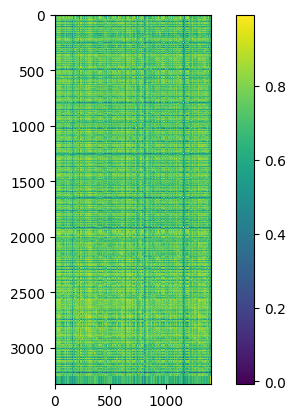

In [164]:

# Create a sample 2D array
data = np.load("vectorize_with_start_token_128_128_1/spark/sim_scores_13155149_13217285.npz")["arr_0"]

# Plotting the heatmap
plt.imshow(data, cmap='viridis', interpolation='nearest')

# Adding colorbar
plt.colorbar()

# Show the plot
plt.show()

In [166]:
len(selected_bug_ids)

644

# Sandbox

In [261]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
import torch

In [278]:
config = AutoConfig.from_pretrained('bert-base-cased', output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = model = AutoModel.from_pretrained('bert-base-cased', config=config).eval()

Downloading: 100%|██████████| 433/433 [00:00<00:00, 264kB/s]
Downloading: 100%|██████████| 213k/213k [00:00<00:00, 2.01MB/s]
Downloading: 100%|██████████| 436M/436M [00:06<00:00, 72.3MB/s] 


In [327]:
# text1 = "sqlite create table"
# text2 = "select rows from table in database"
# text3 = "get maximum value from array python"
# text4 = "vscodeServer"

# texts = [
#     text1,
#     text2,
#     text3,
#     text4,
# ]

text1 = 'I like living in New York.'
text2 = 'New York is a prosperous city.'
text3 = 'sqlite create table'


texts = [
    text1,
    text2,
    text3,
]


In [328]:
def get_tids(text):
    tokens = [tokenizer.cls_token] + tokenizer.tokenize(text) + [tokenizer.sep_token]
    return tokenizer.convert_tokens_to_ids(tokens)

In [329]:
token_ids = [get_tids(s) for s in texts]

In [332]:
context_embeddings = [model(torch.tensor(token_id)[None,:])[0] for token_id in token_ids]
last_hidden_states = [model(torch.tensor(token_id)[None,:])[1] for token_id in token_ids]
# hidden_states = [model(torch.tensor(token_id)[None,:])[2] for token_id in token_ids]

In [331]:
avgs = [hidden_state[-1].squeeze()[0].reshape(1, -1) for hidden_state in hidden_states]

In [284]:
torch.cosine_similarity(avgs[0], avgs[1])

tensor([0.9588], grad_fn=<SumBackward1>)

In [269]:
torch.cosine_similarity(avgs[1], avgs[2])

tensor([0.9979], grad_fn=<SumBackward1>)

In [270]:
torch.cosine_similarity(avgs[0], avgs[2])

tensor([0.9958], grad_fn=<SumBackward1>)

In [271]:
torch.cosine_similarity(avgs[0], avgs[3])

tensor([0.9983], grad_fn=<SumBackward1>)

In [243]:
last_hidden_states[0].shape

torch.Size([1, 768])

In [259]:
hidden_states[0][0].shape

torch.Size([1, 6, 768])

In [260]:
context_embeddings[0].shape

torch.Size([1, 6, 768])

In [302]:
simmat = similarity_score_matrix_3d(hidden_states[0][-1].detach().numpy(), hidden_states[1][-1].detach().numpy())

In [303]:
for i in simmat:
    print(i)

[0.95881432 0.81340164 0.27639475 0.248918   0.25406659 0.26556334
 0.21036227 0.2850835  0.18575111]
[0.82253033 0.89787728 0.337726   0.34917551 0.34134251 0.34818664
 0.29246762 0.40964958 0.17230548]
[0.21390671 0.23052092 0.5580104  0.69349885 0.6365779  0.63864374
 0.61986732 0.57822394 0.13980871]
[0.20997135 0.25577632 0.63782573 0.68903011 0.65762782 0.66236687
 0.68643349 0.60433245 0.16272467]
[0.22979766 0.28188598 0.64247572 0.72063631 0.69154769 0.68319851
 0.7193833  0.64986163 0.14566295]
[0.178157   0.31929538 0.72069389 0.60981762 0.57698983 0.61283761
 0.69156051 0.5754993  0.16096988]
[0.19248982 0.28145224 0.85266709 0.60118192 0.56161749 0.58813989
 0.70995796 0.57914782 0.20312347]
[0.30916071 0.36176154 0.59637338 0.66745996 0.64191896 0.62200642
 0.65111279 0.89231372 0.28338405]
[0.08487512 0.06124486 0.17682356 0.19140476 0.15023872 0.06126149
 0.17821206 0.25282773 0.80556875]


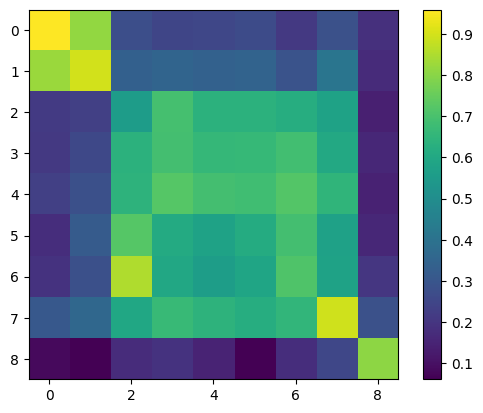

In [305]:
plot_2d_array(simmat)

In [309]:
len(hidden_states[0])

13

In [317]:
for i in range(len(hidden_states)):
    hidden_states[i] = list(hidden_states[i])
    hidden_states[i] = [tensor.detach().numpy() for tensor in hidden_states[i]]
    hidden_states[i] = np.array(hidden_states[i])
    

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [337]:
cls_tokens = [context_embedding[0][0] for context_embedding in context_embeddings]

In [338]:
len(cls_tokens)

3

In [339]:
similarity_score_1d(cls_tokens[0].detach().numpy(), cls_tokens[1].detach().numpy())

0.995136

In [340]:
similarity_score_1d(cls_tokens[0].detach().numpy(), cls_tokens[1].detach().numpy())

0.995136

In [341]:
similarity_score_1d(cls_tokens[0].detach().numpy(), cls_tokens[2].detach().numpy())

0.99597067

In [39]:
# def code_bert_similarity(text1, text2):
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")
    
    

NameError: name 'AutoTokenizer' is not defined

In [40]:
text1 = \
"""def get_max(my_list):
if not my_list:
    raise ValueError("Input list is empty")

max_element = max(my_list)
return max_element
"""

text2 = \
"""def m(L):
largest = L[0]
for element in L:
    if element > largest:
        largest = element
return largest"""

text3 = \
"""def m(L):
    t = 0
    c = 0
    for e in L:
        t += e
        c += 1
    return t/c"""
    
text4 = \
"""int getMaxValue(const int arr[], int size) {
    if (size <= 0) {
        // Handle empty array or invalid size
        std::cerr << "Invalid array size or empty array." << std::endl;
        return -1; // You can choose a suitable default value or throw an exception
    }

    int max_value = arr[0]; // Assume the first element is the maximum

    for (int i = 1; i < size; ++i) {
        if (arr[i] > max_value) {
            // Update max_value if a larger element is found
            max_value = arr[i];
        }
    }

    return max_value;
}"""

text5 = \
"""int getLastValue(const int arr[], int size) {
    if (size <= 0) {
        // Handle empty array or invalid size
        std::cerr << "Invalid array size or empty array." << std::endl;
        return -1; // You can choose a suitable default value or throw an exception
    }

    return arr[size - 1];
}"""

text_desc1 = "return max value of a list"
text_desc2 = "return average value of a list"

sentences = [text1, text2, text3, text4, text5, text_desc1, text_desc2]
tokens = {'input_ids': [], 'attention_mask': []}

In [41]:
tokens = [tokenizer.tokenize(s) for s in sentences]

AttributeError: 'property' object has no attribute 'tokenize'

In [42]:
token12 = [tokenizer.cls_token]+tokens[0]+[tokenizer.sep_token]+tokens[1]+[tokenizer.eos_token]
token13 = [tokenizer.cls_token]+tokens[0]+[tokenizer.sep_token]+tokens[2]+[tokenizer.eos_token]
token23 = [tokenizer.cls_token]+tokens[1]+[tokenizer.sep_token]+tokens[2]+[tokenizer.eos_token]

AttributeError: 'property' object has no attribute 'cls_token'

In [37]:
token_id_12 = tokenizer.convert_tokens_to_ids(token12)
token_id_13 = tokenizer.convert_tokens_to_ids(token13)
token_id_23 = tokenizer.convert_tokens_to_ids(token23)

AttributeError: 'property' object has no attribute 'convert_tokens_to_ids'

In [38]:
context_embeddings12 = model(torch.tensor(token_id_12)[None,:])[0]
context_embeddings13 = model(torch.tensor(token_id_13)[None,:])[0]

NameError: name 'token_id_12' is not defined

In [374]:
context_embeddings12[0][0].shape

torch.Size([768])

In [375]:
sigmoid12 = torch.sigmoid(context_embeddings12[0][0])
sigmoid13 = torch.sigmoid(context_embeddings13[0][0])

In [376]:
similarity_score_1d(sigmoid12.detach().numpy(), sigmoid13.detach().numpy())

0.9997811

In [377]:
sigmoid12[:10]

tensor([0.4546, 0.5247, 0.4767, 0.5593, 0.5282, 0.4299, 0.5483, 0.5072, 0.5874,
        0.3844], grad_fn=<SliceBackward0>)

In [378]:
sigmoid13[:10]

tensor([0.4538, 0.5242, 0.4851, 0.5542, 0.5389, 0.4233, 0.5413, 0.5101, 0.5999,
        0.3936], grad_fn=<SliceBackward0>)

In [379]:
context_embeddings12

tensor([[[-0.1821,  0.0990, -0.0934,  ..., -0.2062, -0.4784,  0.4663],
         [-1.0884, -0.0540,  0.5363,  ..., -1.2817, -0.1653,  0.6422],
         [-0.6102,  0.0918,  0.1416,  ..., -0.2185, -0.1030,  0.8381],
         ...,
         [-0.5921, -0.0649,  0.2725,  ..., -0.2639, -0.3881,  0.8463],
         [-0.4841,  0.1232,  0.4669,  ..., -0.8814, -0.8760,  0.5709],
         [-0.1822,  0.0996, -0.0931,  ..., -0.2076, -0.4788,  0.4667]]],
       grad_fn=<NativeLayerNormBackward0>)

In [380]:
context_embeddings13

tensor([[[-0.1853,  0.0968, -0.0598,  ..., -0.2449, -0.4823,  0.5246],
         [-1.1060, -0.1273,  0.5824,  ..., -1.2100, -0.1478,  0.5801],
         [-0.6145,  0.0517,  0.1157,  ..., -0.1530, -0.1261,  0.7626],
         ...,
         [-0.1335,  0.4419,  0.1217,  ...,  0.0102, -0.4233,  0.6430],
         [-0.5602,  0.3650,  0.4866,  ..., -1.6851, -0.6421,  0.3791],
         [-0.1868,  0.0979, -0.0587,  ..., -0.2477, -0.4829,  0.5256]]],
       grad_fn=<NativeLayerNormBackward0>)

In [73]:
from sentence_transformers import SentenceTransformer, util

In [74]:
model = SentenceTransformer('all-MiniLM-L6-v2')
tokenizer = SentenceTransformer.tokenizer

In [45]:
sent_embeddings = [model.encode(sentence,convert_to_tensor=True) for sentence in sentences]

In [46]:
util.pytorch_cos_sim(sent_embedding1, sent_embedding2)

tensor([[0.6673]])

In [47]:
util.pytorch_cos_sim(sent_embedding1, sent_embedding3)

tensor([[0.2244]])

In [48]:
util.pytorch_cos_sim(sent_embedding2, sent_embedding3)

tensor([[0.3698]])

In [49]:
util.pytorch_cos_sim(sent_embeddings[0], sent_embeddings[1])

tensor([[0.5971]])

In [50]:
util.pytorch_cos_sim(sent_embeddings[3], sent_embeddings[4])

tensor([[0.7790]])

In [82]:
def get_sim_score_matrix(sentences):
    sent_embeddings = [model.encode(sentence,convert_to_tensor=True) for sentence in sentences]
    length = len(sentences)
    ret = np.zeros((length, length))
    for i in range(length):
        for j in range(i+1, length):
            ret[i, j] = util.pytorch_cos_sim(sent_embeddings[i], sent_embeddings[j])
    plot_2d_array(ret)
    return ret  
    
        
    

In [86]:
text1 = "Index is out of bound"
text2 = "Index is not in range"
text3 = "Out of memory error"

sentences = [
    text1,
    text2,
    text3,
]

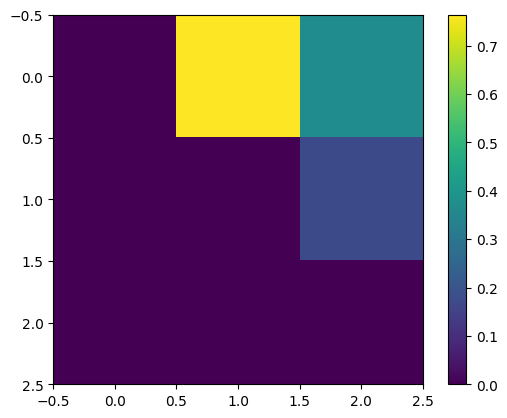

[[0.         0.76405334 0.37143177]
 [0.         0.         0.17051716]
 [0.         0.         0.        ]]


In [87]:
print(get_sim_score_matrix(sentences))